## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import yfinance
import cpi


## Data preparation

In [2]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie preparation

In [3]:
def movie_data_processing():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))
    movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
    return movies
movies = movie_data_processing()

In [4]:
def process_dict_columns(movies):
    """
    This function processes the columns containing dictionaries in the movies dataframe
    It delets some categories with less than Min_..._count movies and deletes movies with no categories left
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])
    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))

    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)
    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))

    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)
    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)
    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))
        
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))
    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [5]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    """
    This function processes the movie release date column
    It deletes movies with no release date and modifies the format of the date
    For the movies with no precise release date, it sets the release date to the 1st of January of the year of the movie
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    movies: pandas dataframe
        The dataframe containing the processed data
    """
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    #little error in the date
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))
    return movies

movies = modify_movie_release_date(movies)

### Mergin revenue column with TMDB and adding budget

In [6]:
def modif_name(x):
    """
    Helper function to merge the movies dataframes on name and release year
    """
    if x[0].lower() in movies['modified name'].values:
        return x[0].lower()
    elif x[1].lower() in movies['modified name'].values:
        return x[1].lower()
    else:
        return False

def merge_revenue(x):
    """
    Helper function to merge the revenues from all the dataframes joined
    """
    if x['Movie box office revenue']>0:
        return x['Movie box office revenue']
    elif x['revenue_left']>0:
        return x['revenue_left']
    elif x['revenue_right']>0:
        return x['revenue_right']
    else:
        return np.nan

def merge_budget(x):
    """
    Helper function to merge the budgets from all the dataframes joined
    """
    if type(x['budget_left'])==str and int(x['budget_left'])>0:
        return int(x['budget_left'])
    elif type(x['budget_right'])==str and int(x['budget_right'])>0:
        return int(x['budget_right'])
    else:
        return np.nan

def merging_revenu_budget(movies):

    """
    This function merges the movies dataframe with the data from the other datasets
    It merges on the name and the release year
    It also merges the revenue and the budget
    Parameters
    ----------
    movies: pandas dataframe
        The dataframe containing the movies data
    Returns
    -------
    full_joined: pandas dataframe
        The dataframe containing the processed data
    """
    tmdb_scrapped = pd.read_csv('data/tmdb_scrapped_full.csv')
    tmdb_scrapped['release_year']=tmdb_scrapped['release_date'].map(lambda x: int(x.split('-')[0]))
    the_movies = pd.read_csv("data/the-movies-dataset/movies_metadata.csv")
    the_movies.dropna(subset=['title','original_title','release_date'],inplace=True)
    the_movies['release_year']=the_movies['release_date'].map(lambda x: int(x.split('-')[0]))
    movies['modified name']=movies['Movie name'].map(lambda x: x.lower())
    
    names = []
    for i in the_movies.index:
        names.append(modif_name(the_movies.loc[i,['title','original_title']]))
    the_movies['modified name']=names

    names = []
    for i in tmdb_scrapped.index:
        names.append(modif_name(tmdb_scrapped.loc[i,['title','original_title']]))
    tmdb_scrapped['modified name']=names
    
    temporary_joined = movies.join(the_movies.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined = temporary_joined.join(tmdb_scrapped.set_index(['modified name',"release_year"]), on=['modified name','Movie Year Release'], how='left', lsuffix='_left', rsuffix='_right')
    full_joined.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)

    L= []
    for i in full_joined.index:
        L.append(merge_revenue(full_joined.loc[i]))
    full_joined['full revenue']=L

    L1= []
    for i in full_joined.index:
        L1.append(merge_budget(full_joined.loc[i]))
    full_joined['full budget']=L1

    full_joined.drop(['modified name',"adult_left","belongs_to_collection_left",'budget_left', 'genres_left', 'homepage_left', 'id_left','imdb_id_left', 'original_language_left', 'original_title_left',
       'overview_left', 'popularity_left', 'poster_path_left','production_companies_left', 'production_countries_left','release_date_left', 'revenue_left', 'runtime_left',
       'spoken_languages_left', 'status_left', 'tagline_left', 'title_left','video_left', 'vote_average_left', 'vote_count_left', 'Unnamed: 0.1','Unnamed: 0', 'adult_right', 'backdrop_path',
       'belongs_to_collection_right', 'budget_right', 'genres_right','homepage_right', 'id_right','original_language_right', 'original_title_right', 'overview_right',
       'popularity_right', 'poster_path_right', 'production_companies_right','production_countries_right', 'release_date_right', 'revenue_right','runtime_right', 'spoken_languages_right', 'status_right','tagline_right', 'title_right', 'video_right', 'vote_average_right',
       'vote_count_right'],axis=1,inplace=True)
    
    full_joined.drop(['Movie box office revenue'],axis=1,inplace=True)
    full_joined.rename(columns={'imdb_id_right':'IMDB id','full revenue':'Movie box office revenue','full budget':'Movie budget'},inplace=True)
    return full_joined

full_joined = merging_revenu_budget(movies)

#or this if you want to gain time:
# full_joined = pd.read_csv('data/movie_with_merged_revenue.csv')
movies=full_joined.copy()

C:\Users\maxen\AppData\Local\Temp\ipykernel_4576\3937326034.py:53: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  the_movies = pd.read_csv("data/the-movies-dataset/movies_metadata.csv")


### Characters

In [7]:
def characters_data_process():
    """
    This function loads the characters data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    characters: pandas dataframe
        A dataframe containing the processed data
    """
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    ## This one might be usefull
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)
    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    #little error in the date
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)
    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    return characters
characters = characters_data_process()

### Plot Summaries

In [8]:
def plot_summaries_data_process():
    """
    This function loads the plot summary data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    plot_summaries: pandas dataframe
        A dataframe containing the processed data
    """
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### Add rotten tomatoes critic score

In [9]:
def processing_rotten_tomatoes_score():
    """
    This function loads the data from the MovieSummaries dataset and processes it to be used in the analysis
    Returns
    -------
    movies: pandas dataframe
        A dataframe containing the processed data
    """
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)
    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating','original_release_date'], inplace=True)
    rotten_movies['Movie Year Release'] = rotten_movies['original_release_date'].map(lambda x: int(x.split('-')[0]))
    
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()

# join on movie name and release year
joined_2_movies = movies.join(rotten_movies.set_index(['movie_title', 'Movie Year Release']), on=['Movie name', 'Movie Year Release'], how='left')
joined_2_movies.drop_duplicates(subset=['Wikipedia movie ID'],inplace=True)
# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

#OK but still some film have different release data on the two dataset=> Wilde 
movies = joined_2_movies

### First definition of success

In [10]:

mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

movies["Finantial Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold
#make that when Normalized revenue is nan, Finantial Success is nan
movies.loc[movies["Movie box office revenue"].isna(), "Finantial Success"] = np.nan


# Financial success

We load CPI data to compare the movie box office return through history. Furthermore, we load financial data to analyse if economics data are related with success for some period 

## Analysis of inflation

In [11]:
# we import consumer price index (CPI) prices from the cpi python library

cpi_df = cpi.series.get().to_dataframe()
cpi_df = cpi_df[cpi_df['period_type']=='monthly']
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df = cpi_df.set_index('date').sort_values(by="date")

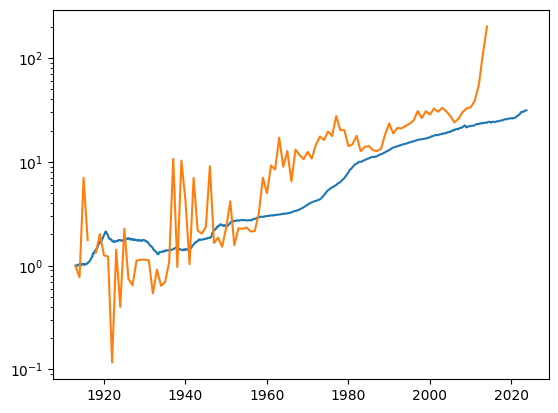

In [12]:
# we plot normalized revenue wrt the beginning of data, for both CPI and movie revenues

mean_revenue_year.index = pd.to_datetime(mean_revenue_year.index, format="%Y")
plt.semilogy(cpi_df["value"]/(cpi_df["value"].iloc[0]))
plt.semilogy(mean_revenue_year/mean_revenue_year.dropna().iloc[0])


### Adjust the effect of inflation on the movie revenue

In [13]:
# we add an inflated revenue column, corresponding to the movie box office revenue increased to today's value according to inflation

movies["Inflated revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]) if (not(np.isnan(x["Movie box office revenue"])))else None, axis=1)

## Financial success

We now compare a financial indicator with the increase of movie revenue through history

In [14]:

# importing S&P 500 data to compare with movie revenue

financial_indicator = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max(), format="%Y"))



[*********************100%%**********************]  1 of 1 completed


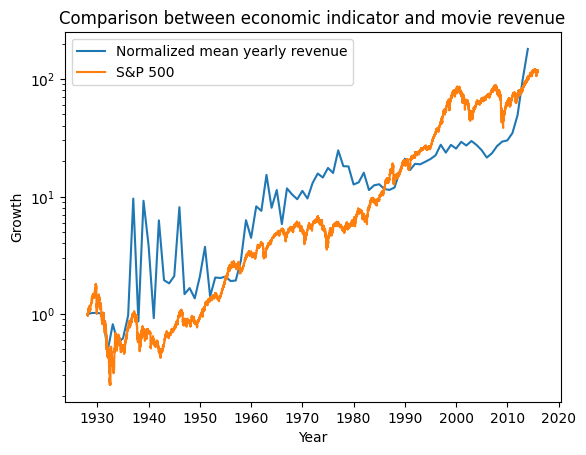

In [15]:
# we plot normalized revenue wrt the beginning of data, for both economic data and movie revenues

financial_revenue_year = mean_revenue_year[mean_revenue_year.index.year>financial_indicator.index.year.min()]
financial_revenue_year.index = pd.to_datetime(financial_revenue_year.index, format="%Y") 
plt.semilogy(financial_revenue_year/financial_revenue_year[0], label="Normalized mean yearly revenue")
plt.semilogy(financial_indicator["Close"]/financial_indicator["Close"][0], label="S&P 500")
plt.title("Comparison between economic indicator and movie revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

In [ ]:
# We will then need to compute correlation between our financial indicator and our movie revenue

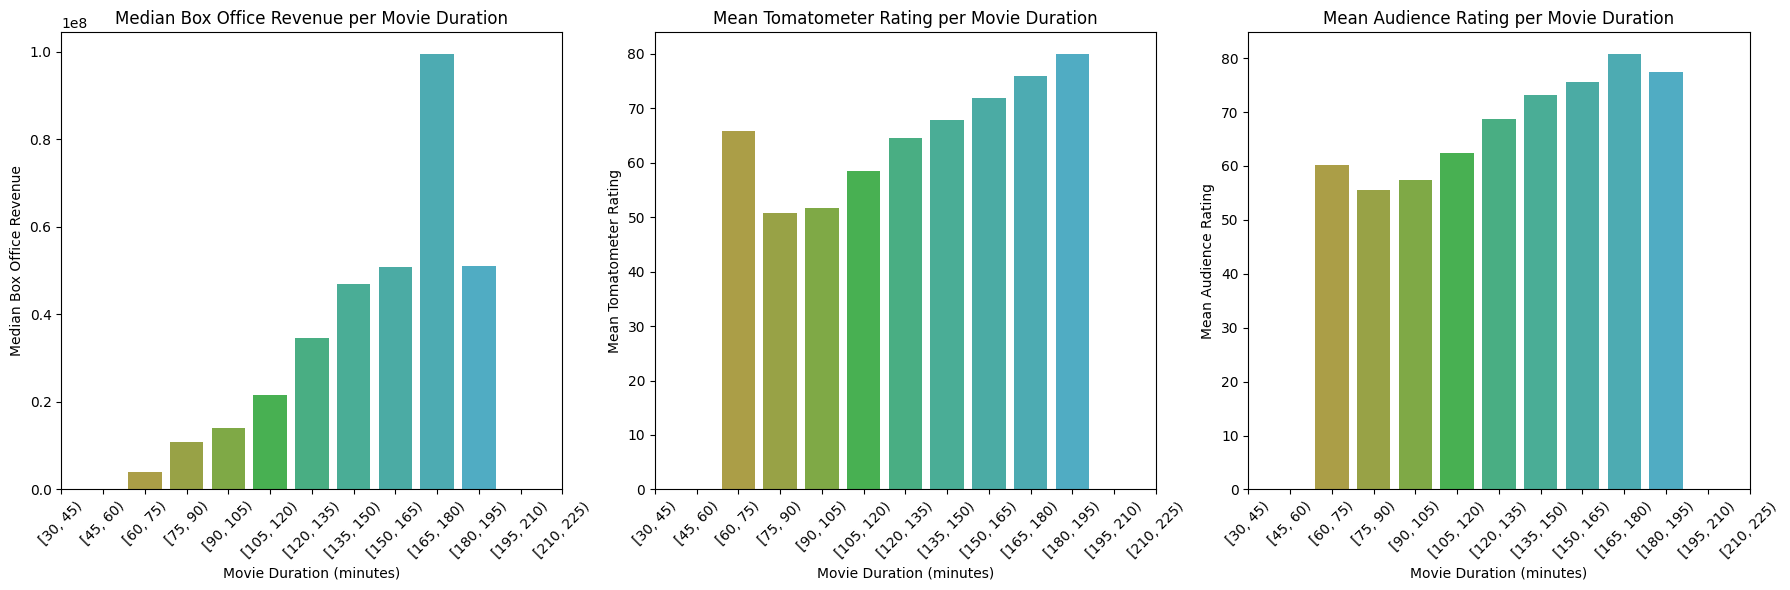

In [ ]:
from helpers import convert_and_extract_date, create_length_bins, plot_movie_duration_metrics, explore_month_release_relationship
# Convert the movie release dates to datetime format and extract month and year from the datetime values
movies = convert_and_extract_date(movies)
# Create bins for movie length with a step of 15 minutes up to 300 minutes
filtered_movies, grouped_data = create_length_bins(movies)
# Compare the plots per movie duration for: median box office revenue, mean tomatometer_rating and mean audience_rating
plot_movie_duration_metrics(grouped_data)

## Movie Duration Graph Analysis & Comparison

A common trend in all 3 graphs is the strict increase of 'success' from the 75-90' movie bucket to the 165-180' movie bucket. We only considered buckets with a large enough sample size to provide more useful insight, a minimum threshold of 25 movie occurrences. Extreme values of box office revenues could heavily influence the mean, so we took the median as we have a big enough sample size and more importantly unskewed data.

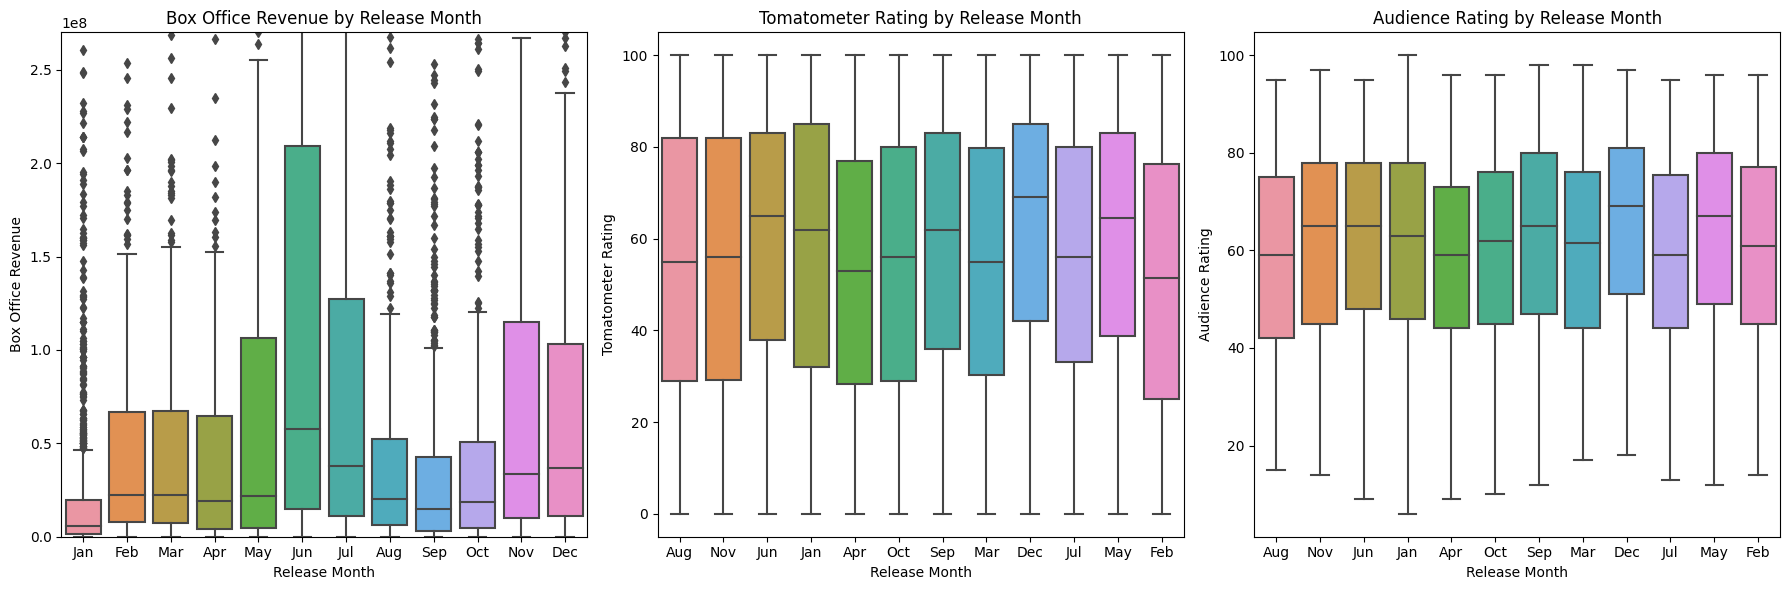

In [ ]:
# View the boxplots in monthly order with literal month abbreviations
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Compare the plots per release month for: box office revenue, tomatometer_rating and audience_rating
explore_month_release_relationship(movies, month_order)

### Release Month Graph Analysis & Comparison

It makes sense that there is no significant relation between movie ratings and release month. The interesting plot here is the box office revenue per release month. June, July, November and December are clearly the most profitable movie release months, most likely due to the holiday seasons that can attract more viewers to cinemas. We also notice that the months that follow the holiday season are extremely unprofitable for movie releases, notably January and September: students go back to school after the summer/christmas holidays and general consumers may want to spend less money after their holiday expenses. 